In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style("whitegrid")
plt.rc('font', family='Times New Roman', size=20)

df = pd.read_excel('market_price_202122.xlsx', sheet_name='Sheet1')
pv = pd.read_excel('pv_data.xlsx', sheet_name='Sheet1')
pl= pd.read_excel('PL.xlsx', sheet_name='Sheet1')


In [37]:
df['date'] = pd.to_datetime(df['date']).dt.date
df['time'] = df['time'].astype(str)
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'], format="mixed")
df.drop(columns=['date', 'time'], inplace=True)
df.set_index('datetime', inplace=True)

In [38]:
pv['date'] = pd.to_datetime(pv['date']).dt.date
pv['time'] = pv['time'].astype(str)
pv['datetime'] = pd.to_datetime(pv['date'].astype(str) + ' ' + pv['time'])
pv.drop(columns=['date', 'time'], inplace=True)
pv.set_index('datetime', inplace=True)

In [6]:

pl['date_time'] = pd.to_datetime(pl['date_time'])
pl.set_index('date_time', inplace=True)

In [7]:
pl.head()

,L1
date_time,
2021-08-29 00:00:00,72.025
2021-08-29 01:00:00,86.700
2021-08-29 02:00:00,116.775
2021-08-29 03:00:00,117.175
2021-08-29 04:00:00,63.825


In [8]:
pl.index.dtype

dtype('<M8[ns]')

In [42]:
duplicate_labels = df.index[df.index.duplicated()]
print(duplicate_labels)
df = df.groupby(df.index).mean()

DatetimeIndex(['2020-10-25 03:00:00', '2022-10-30 03:00:00'], dtype='datetime64[ns]', name='datetime', freq=None)


In [44]:
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
df = df.reindex(full_idx)
df.index.freq = 'h'
df = df.interpolate()  

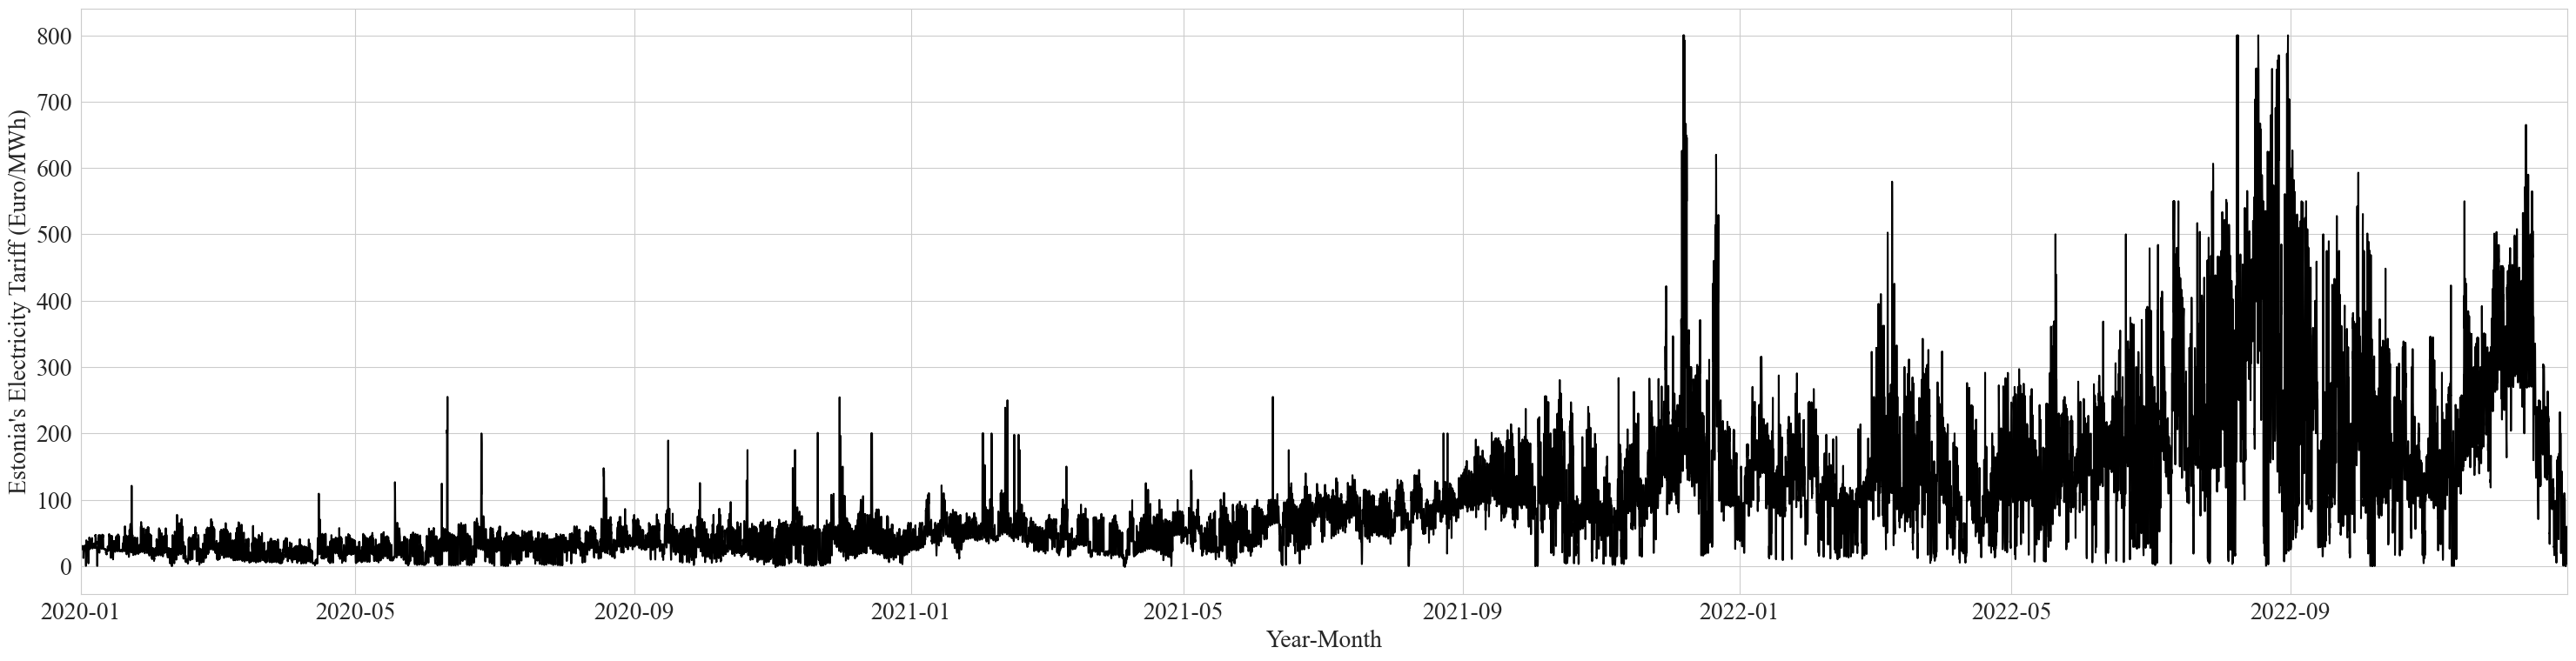

In [48]:
df[df['tariff']>= 800] = 800
fig = plt.figure(figsize=(30, 8))
plt.plot(df, color = 'black')
plt.xlabel('Year-Month')
plt.xlim([df.index.min(), df.index.max()])
plt.ylabel('Estonia\'s Electricity Tariff (Euro/MWh)')
plt.tight_layout()
plt.savefig('tariff.png', dpi=300)

In [21]:
pl.index.year

Index([2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
       ...
       2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
      dtype='int32', name='date_time', length=8773)

In [ ]:
pl_january= pl[ (pl.index.year == 2022)]
pl_january= pl_january[ (pl_january.index.month == 1)]
pl_january= pl_january[ (pl_january.index.day == 10)]

In [46]:
pl_january.index

DatetimeIndex(['2022-01-10 00:00:00', '2022-01-10 01:00:00',
               '2022-01-10 02:00:00', '2022-01-10 03:00:00',
               '2022-01-10 04:00:00', '2022-01-10 05:00:00',
               '2022-01-10 06:00:00', '2022-01-10 07:00:00',
               '2022-01-10 08:00:00', '2022-01-10 09:00:00',
               '2022-01-10 10:00:00', '2022-01-10 11:00:00',
               '2022-01-10 12:00:00', '2022-01-10 13:00:00',
               '2022-01-10 14:00:00', '2022-01-10 15:00:00',
               '2022-01-10 16:00:00', '2022-01-10 17:00:00',
               '2022-01-10 18:00:00', '2022-01-10 19:00:00',
               '2022-01-10 20:00:00', '2022-01-10 21:00:00',
               '2022-01-10 22:00:00', '2022-01-10 23:00:00'],
              dtype='datetime64[ns]', name='date_time', freq=None)

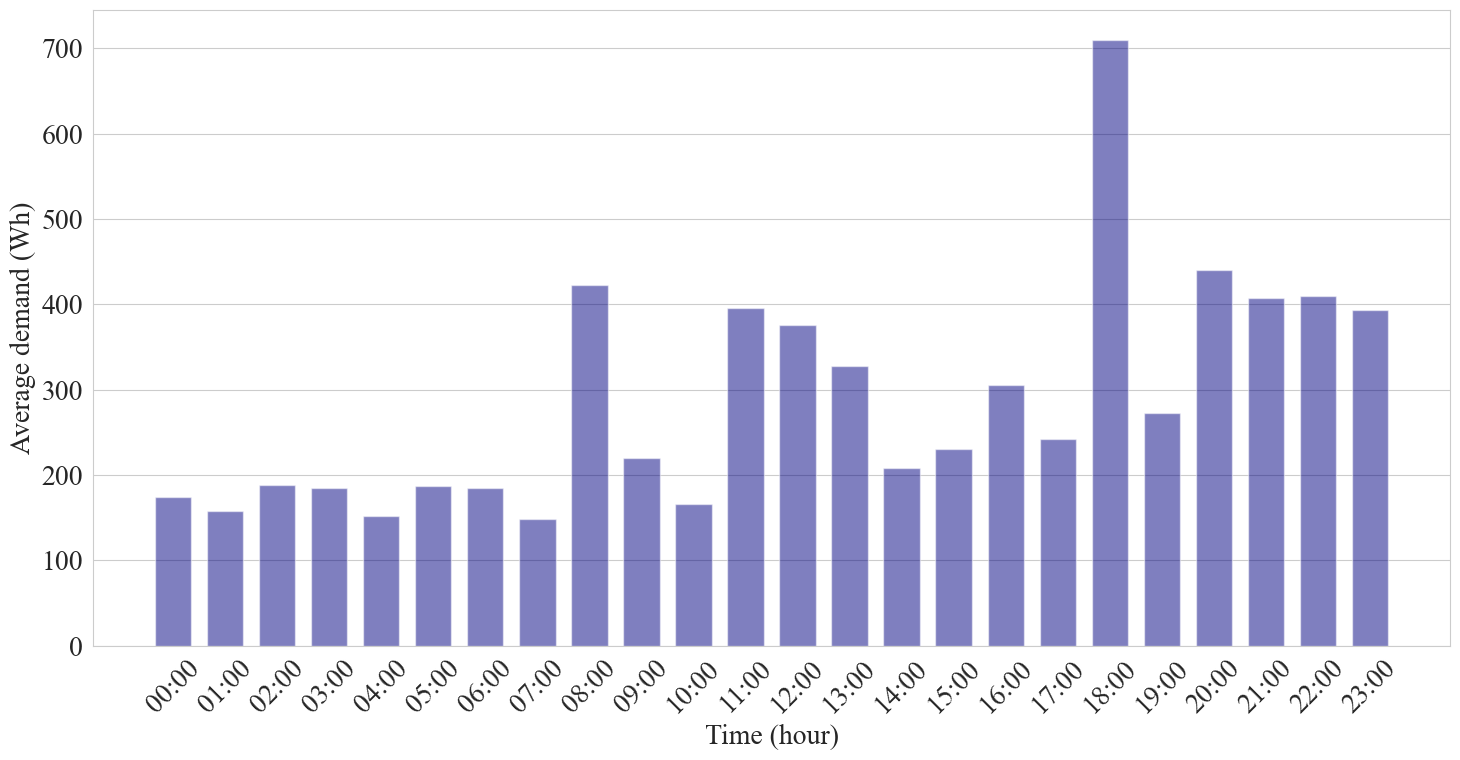

In [56]:
hours = pl_january.index.hour
plt.figure(figsize=(15, 8))
plt.bar(hours, pl_january['L1'], color='navy', width=0.7, align='center', alpha=0.5)
plt.xticks(hours, [f'{hour:02}:00' for hour in hours])
plt.xticks(rotation=45)
plt.ylabel('Average demand (Wh)')
plt.grid(axis='x')
plt.xlabel('Time (hour)')
plt.tight_layout()
plt.savefig('demand.png', dpi=300)

In [83]:
df_mean = df.resample('1d').mean()

In [84]:
df_mean.head()

,tariff
2020-01-01,27.987500
2020-01-02,26.782500
2020-01-03,24.109583
2020-01-04,23.807083
2020-01-05,33.018750


In [85]:
df_mean.size

1096

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_mean, model='additive', period=7)

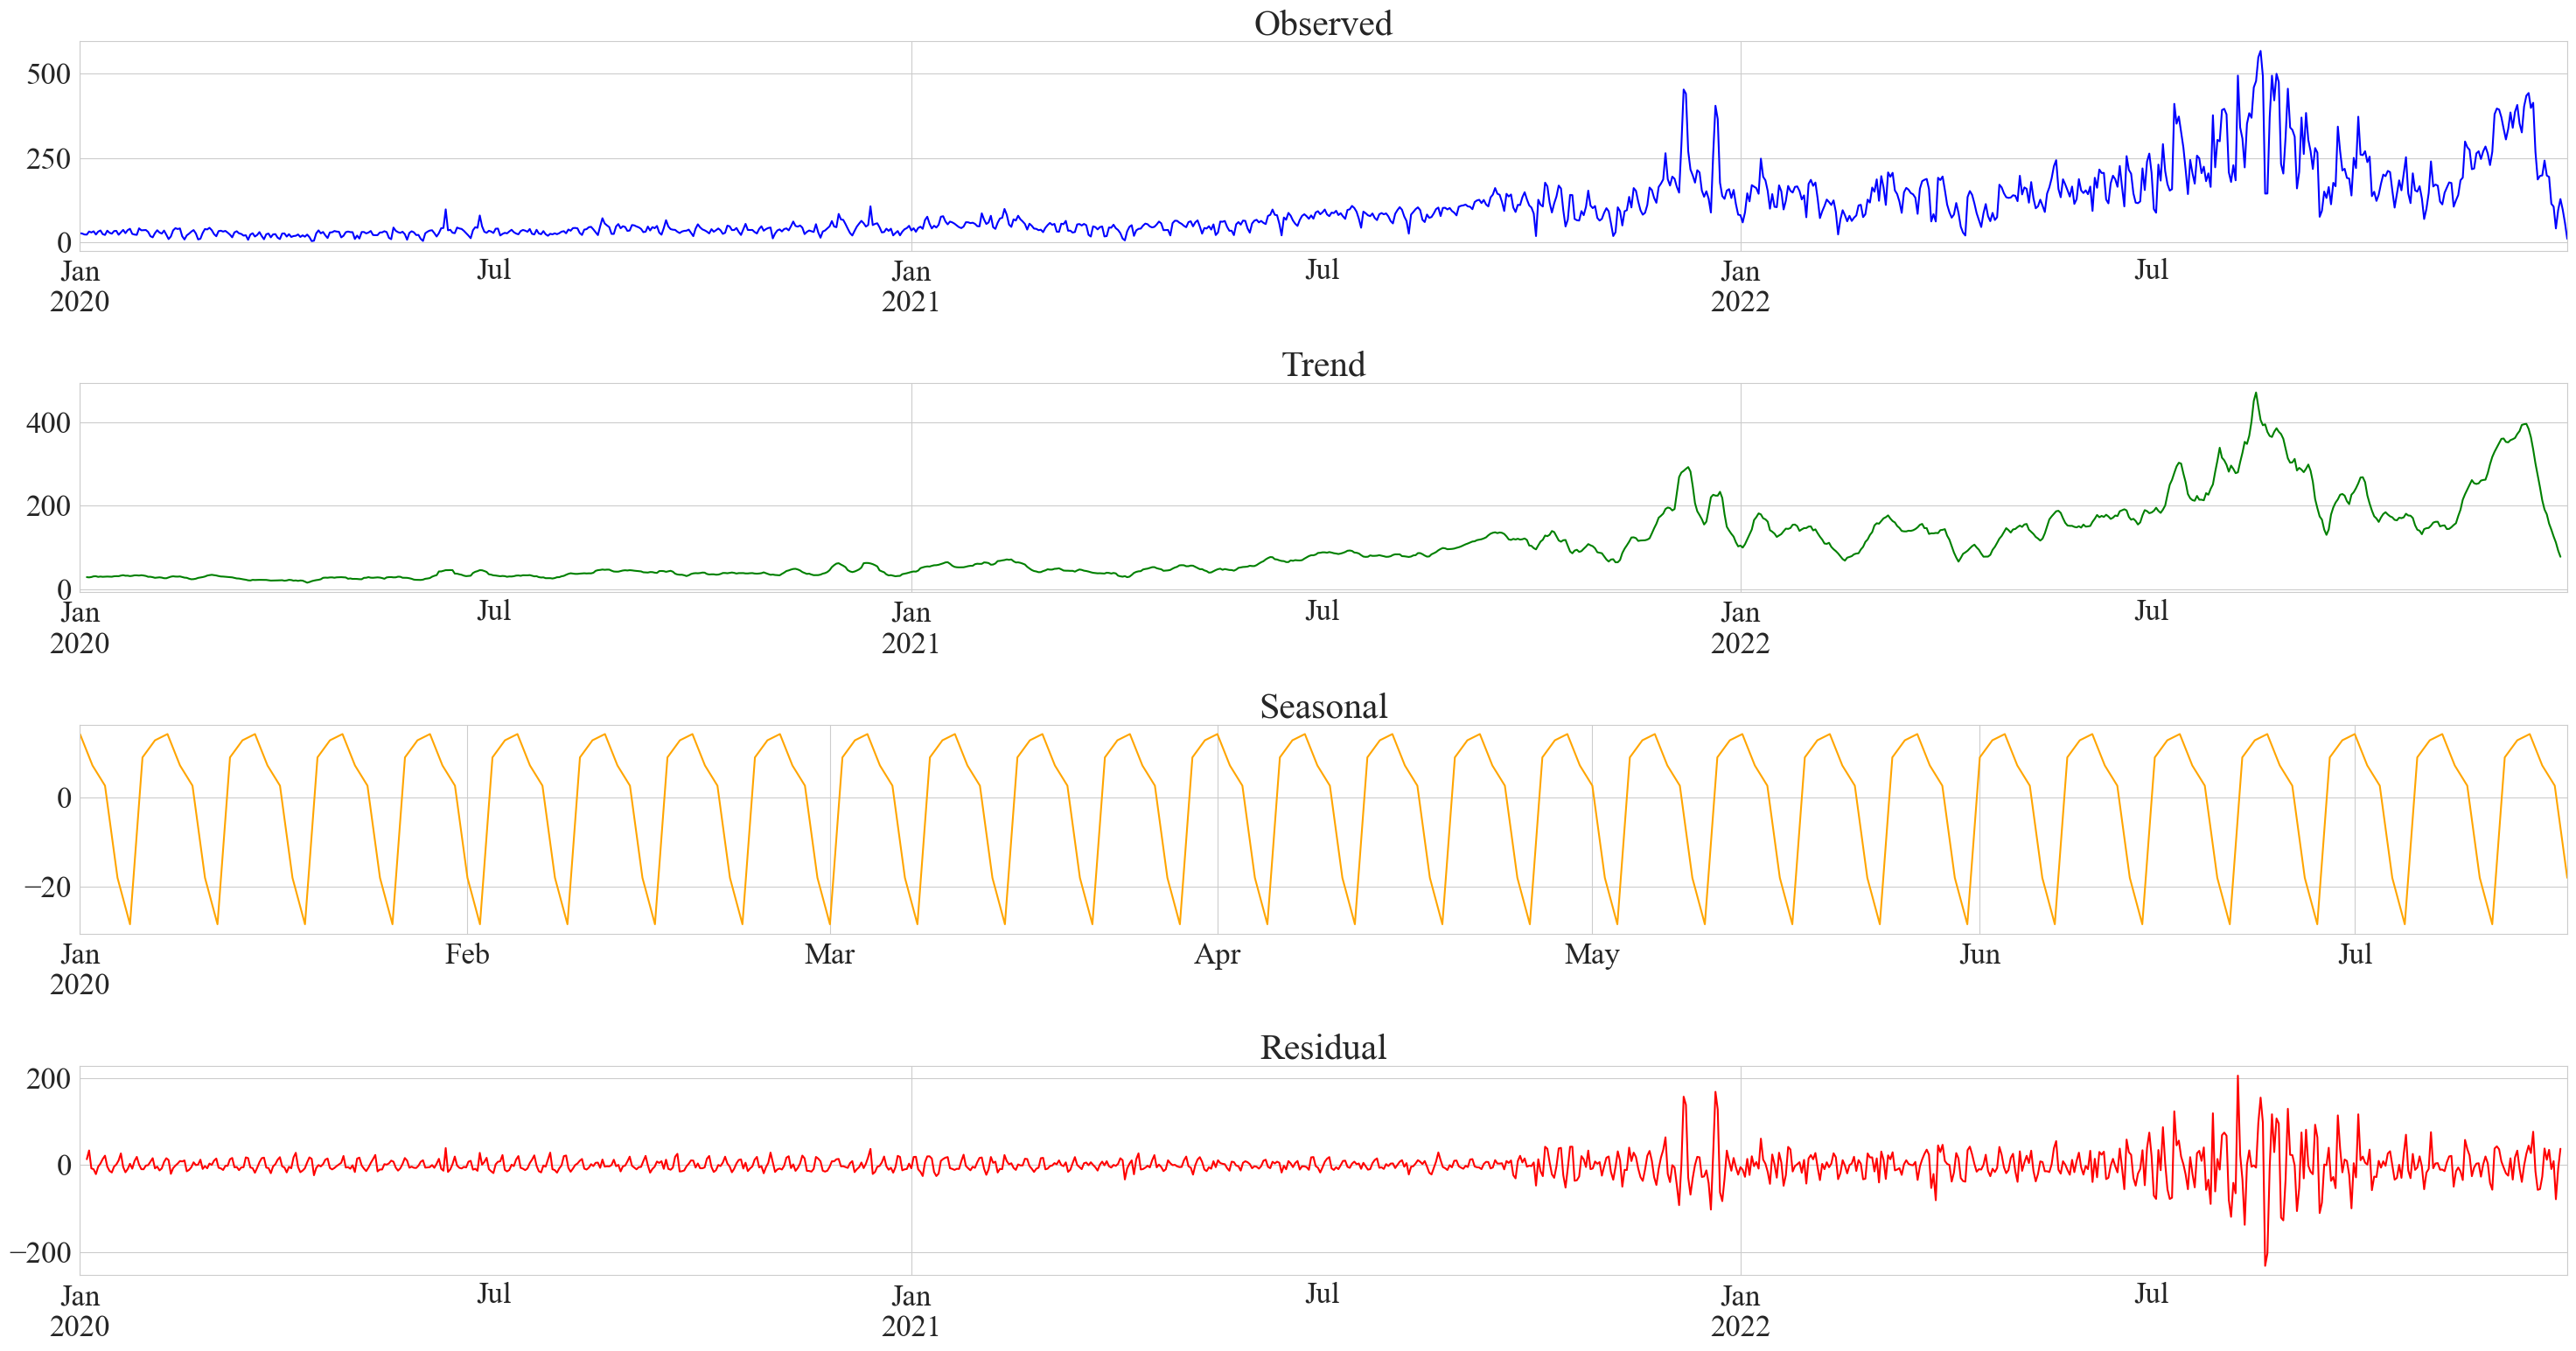

In [96]:
plt.rc('font', family='Times New Roman', size=25)
fig, axes = plt.subplots(4, 1, figsize=(30, 16))  

result.observed.plot(ax=axes[0], title='Observed', color='blue')
result.trend.plot(ax=axes[1], title='Trend', color='green')
result.seasonal[:200].plot(ax=axes[2], title='Seasonal', color='orange')
result.resid.plot(ax=axes[3], title='Residual', color='red')
plt.tight_layout()
plt.show()
fig.savefig('seasonal_decompose.png', dpi=300)

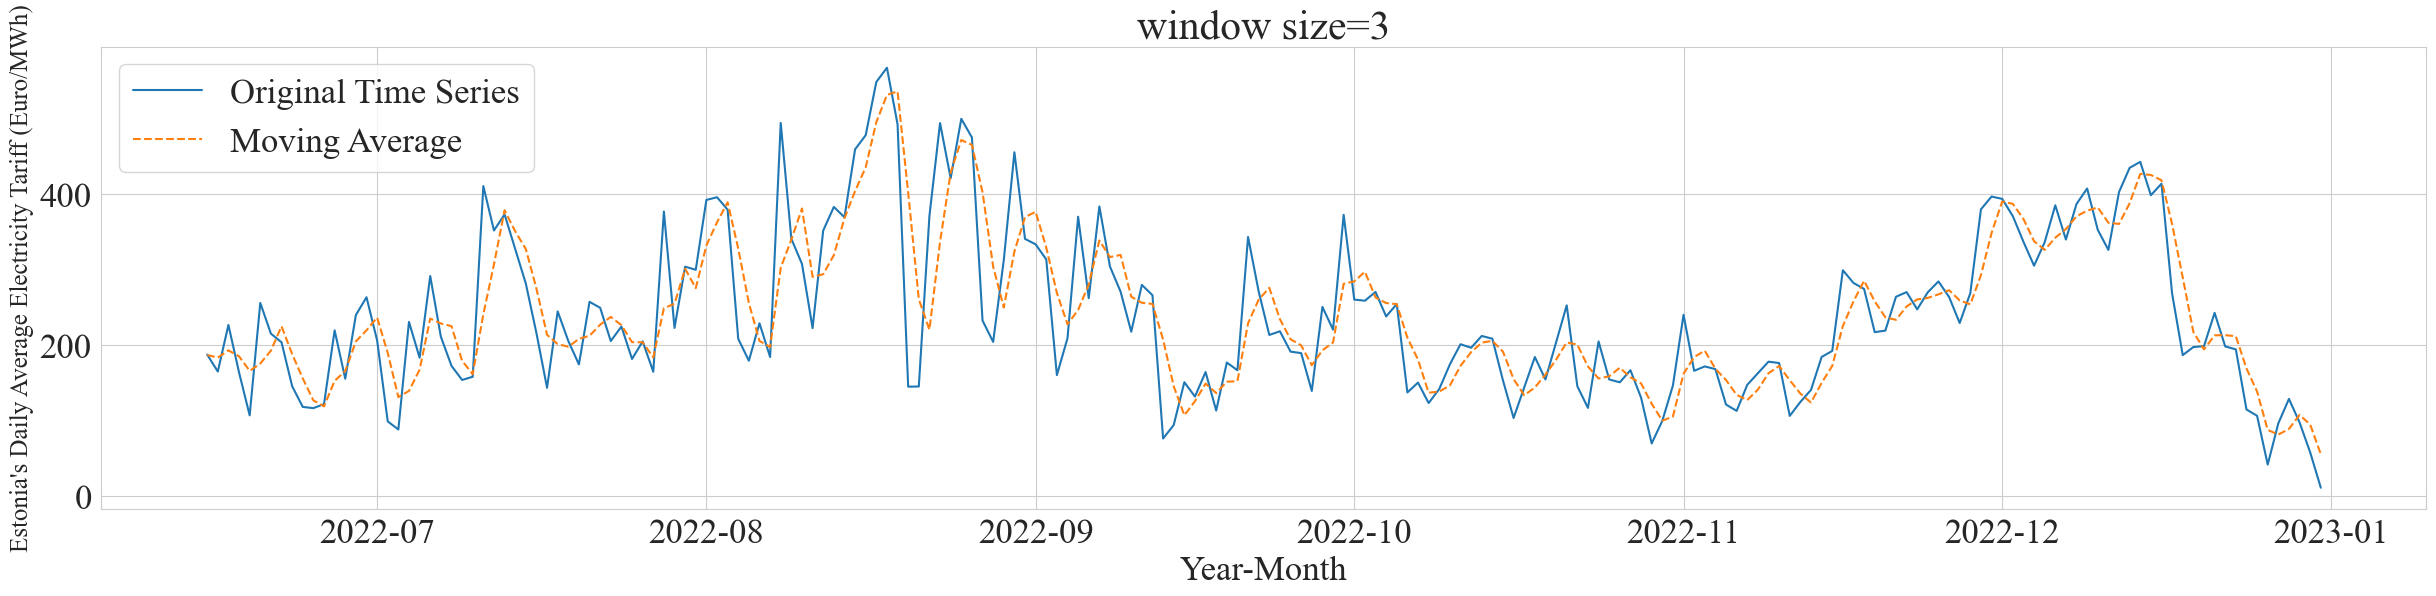

In [119]:

window_size = 3

df_mean['moving_average'] = df_mean['tariff'].rolling(window=window_size).mean()

plt.figure(figsize=(30, 6))
plt.plot(df_mean['tariff'][-200:], label='Original Time Series')
plt.plot(df_mean['moving_average'][-200:], label='Moving Average', linestyle='--')
plt.title(f'window size={window_size}')
plt.xlabel('Year-Month')
plt.ylabel('Estonia\'s Daily Average Electricity Tariff (Euro/MWh)', size=18)
plt.legend()
plt.grid(True)
plt.savefig(f'moving_average_window_size_{window_size}.png', dpi=300)
plt.show()

In [142]:
from statsmodels.tsa.arima.model import ARIMA

order_q = 60
n_periods = 10

model = ARIMA(df['tariff'][-365*24:-n_periods], order=(0, 0, order_q))
model_fit = model.fit(method_kwargs={"maxiter": 1000})
# model_fit = model.fit()

In [140]:
forecast = model_fit.forecast(steps=n_periods)

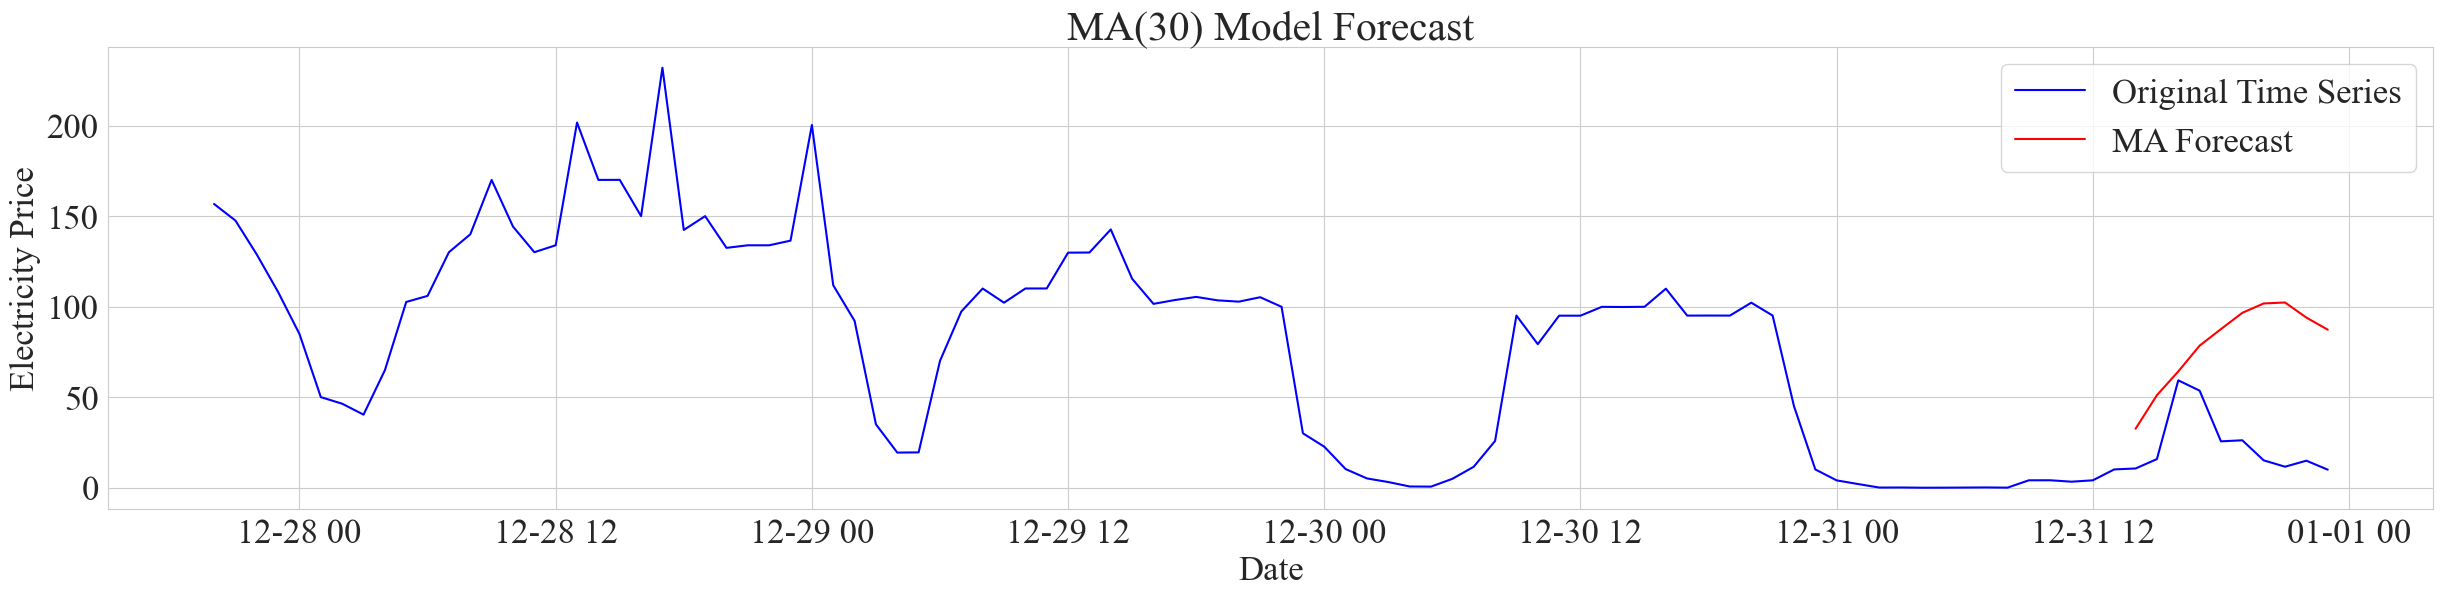

In [141]:

plt.figure(figsize=(30, 6))
plt.plot(df.index[-100:], df['tariff'][-100:], label='Original Time Series', color='blue')
future_dates = pd.date_range(start=df.index[-n_periods-1], periods=n_periods+1, freq='h')[1:] 
plt.plot(future_dates, forecast, label='MA Forecast', color='red')

plt.title(f'MA({order_q}) Model Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.legend()
plt.show()

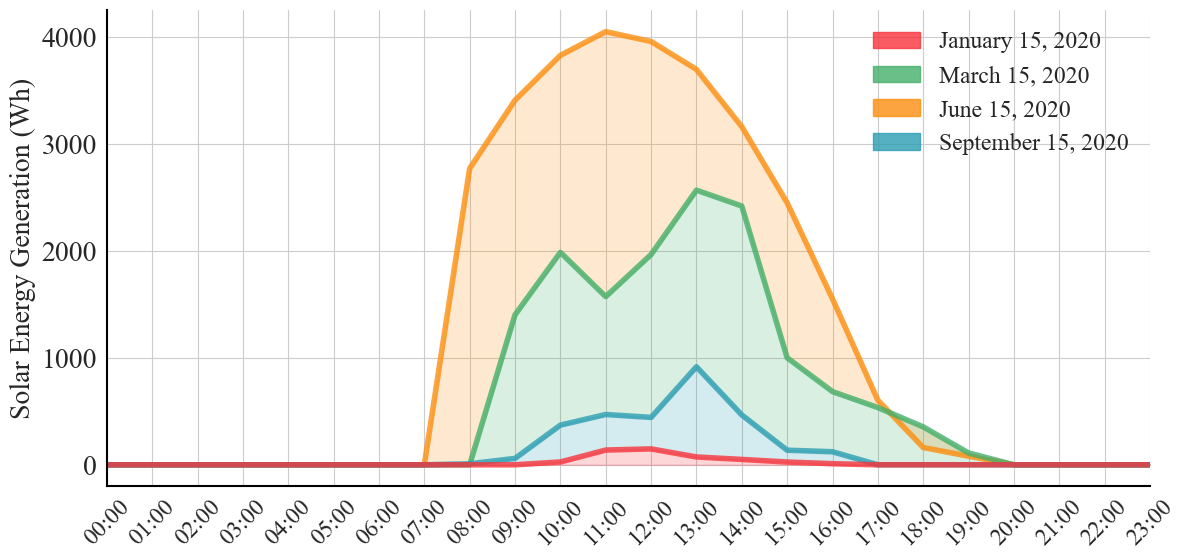

In [4]:
"""Figure 3"""
colors = ['#F8333C', '#3f88c5', '#6A994E',  '#FC8E0F']
colors = ['#FAF02D', '#2b9eb3', '#fc8e0f', '#f8333c']    #44af69
colors = ['#FAF02D', '#44af69', '#2b9eb3', '#fc8e0f']
colors = ['#fc8e0f', '#44af69', '#2b9eb3', '#f8333c'] #'#FAF02D',
pv.index = pv.index.map(lambda dt: dt.replace(year=2000))
jan = (pv.index.month == 1) & (pv.index.day == 15)
march = (pv.index.month == 4) & (pv.index.day == 17)
june = (pv.index.month == 6) & (pv.index.day == 15)
sep = (pv.index.month == 9) & (pv.index.day == 15)
days_order = [june, march, sep, jan]
time_labels = pv.loc[jan].index.strftime('%H:%M')
color_cycle = iter(colors)
fig, ax = plt.subplots(figsize=(12, 6))
prev_y = 0
for day in days_order:
    color = next(color_cycle)
    plt.plot(pv.loc[day].pv.values*5000, linewidth=4, color=color, alpha=0.8)
plt.fill_between(time_labels, pv.loc[june].pv.values*5000, pv.loc[march].pv.values*5000,   alpha=0.2, color=colors[0])
plt.fill_between(time_labels, pv.loc[march].pv.values*5000, pv.loc[sep].pv.values*5000,  alpha=0.2, color=colors[1])  # '#2b9eb3'
plt.fill_between(time_labels, pv.loc[sep].pv.values*5000, pv.loc[jan].pv.values*5000,  alpha=0.2, color=colors[2]) #'#fc8e0f'
plt.fill_between(time_labels, pv.loc[jan].pv.values*5000, 0,  alpha=0.2, color=colors[3]) #

plt.ylabel('Solar Energy Generation (Wh)')
jan_label = mpatches.Patch(color=colors[3], label='January 15, 2020', alpha=0.8)
sep_label = mpatches.Patch(color=colors[2], label='September 15, 2020', alpha=0.8)
march_label = mpatches.Patch(color=colors[1], label='March 15, 2020', alpha=0.8)
june_label = mpatches.Patch(color=colors[0], label='June 15, 2020', alpha=0.8)

plt.legend(handles=[jan_label, march_label, june_label, sep_label], fontsize=17, frameon=False)
# ax.xaxis.grid(False)
plt.xticks(range(len(time_labels)), time_labels, rotation=45, fontsize=17)
# ax.grid(False)

ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

sns.despine()
# labels = ax.get_xticklabels()
# plt.setp(labels, x=2, ha='left')
plt.tight_layout()
# plt.xlim(weekly_avg.index.min(), weekly_avg.index[-2])
plt.xlim(0, 23)
# plt.savefig('solar_gen5.svg', format='svg')
plt.show()

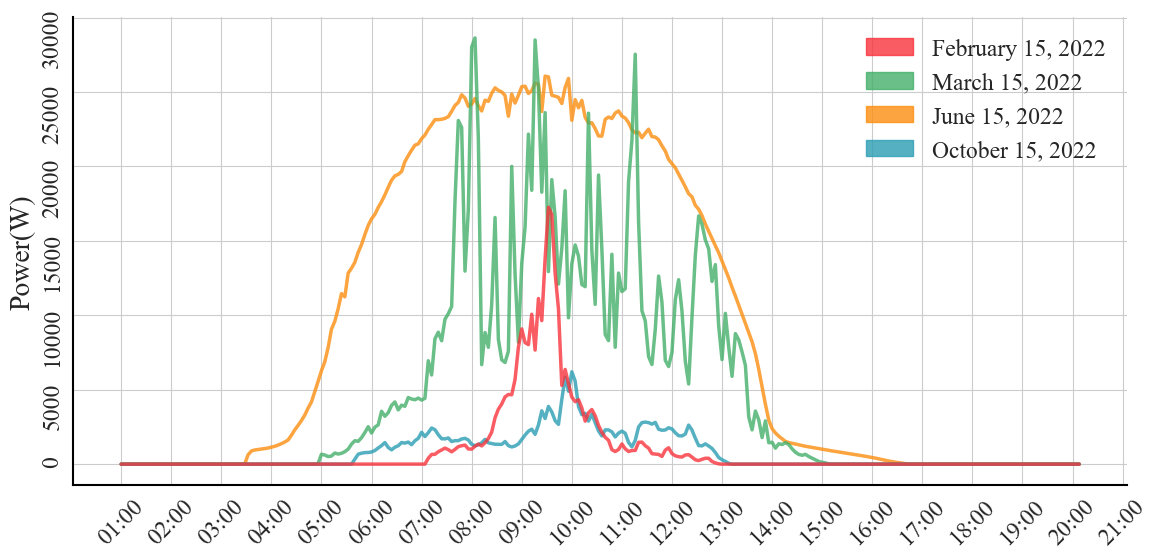

In [6]:
import json
import numpy as np
import warnings
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

sns.set_style("whitegrid")
plt.rc('font', family='Times New Roman', size=20)

with open('solar_panel_data2022.json', 'r') as f:
    data = json.load(f)

times = []
powers = []

for entry in data:
    times.append(entry[0])
    powers.append(entry[1])

for i in range(len(times)):
    times[i] = times[i] / 1000

datetime = pd.to_datetime(times, unit='s')
df = pd.DataFrame({'time': datetime, 'power': powers})
df = df.set_index('time')
df = df.resample('5min').asfreq()
df = df.fillna(0)
df = df.loc['1/1/2022':'12/30/2022']
df['date'] = df.index.date
df['time'] = df.index.time
df['date'] = pd.to_datetime(df['date']).dt.date
df['time'] = df['time'].astype(str)
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'])
df.drop(columns=['date', 'time'], inplace=True)
df.set_index('datetime', inplace=True)
pv = df
pv.power = pv.power/np.max(pv.power)

colors = ['#fc8e0f', '#44af69', '#2b9eb3', '#f8333c']

pv.index = pv.index.map(lambda dt: dt.replace(year=2000))
feb = (pv.index.month == 2) & (pv.index.day == 15)
march = (pv.index.month == 4) & (pv.index.day == 15)
june = (pv.index.month == 6) & (pv.index.day == 15)
oct = (pv.index.month == 10) & (pv.index.day == 15)
month_order = [june, march, oct, feb]
time_labels = pv.loc[feb].index.strftime('%H:%M')
color_cycle = iter(colors)
fig, ax = plt.subplots(figsize=(12, 6))
prev_y = 0
for month in month_order:
    color = next(color_cycle)
    plt.plot(pv.loc[month].power.values*28700, linewidth=2.5, color=color, alpha=0.8)
    
plt.ylabel('Power(W)')
jan_label = mpatches.Patch(color=colors[3], label='February 15, 2022', alpha=0.8)
sep_label = mpatches.Patch(color=colors[2], label='October 15, 2022', alpha=0.8)
march_label = mpatches.Patch(color=colors[1], label='March 15, 2022', alpha=0.8)
june_label = mpatches.Patch(color=colors[0], label='June 15, 2022', alpha=0.8)

plt.legend(handles=[jan_label, march_label, june_label, sep_label], fontsize=17, frameon=False)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=len(time_labels)//12))
ax.set_xticklabels(pv.loc[feb].index[::12].strftime('%H:%M'), rotation=45, fontsize=17)
plt.yticks(fontsize=17, rotation=90)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

sns.despine()
plt.tight_layout()
plt.savefig('solar_gen_farm.png', format='png')
plt.show()



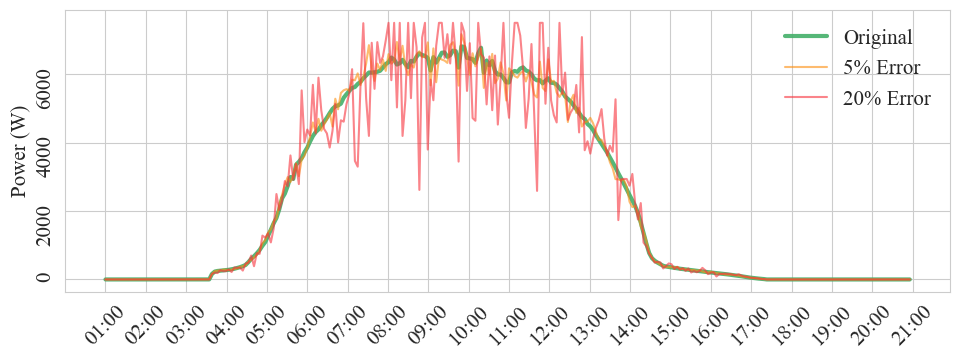

In [10]:
error_20 = np.random.normal(loc=0, scale=0.2, size=len(pv))
error_5 = np.random.normal(loc=0, scale=0.05, size=len(pv))
error_10 = np.random.normal(loc=0, scale=0.1, size=len(pv))



df_2022_with_errors_5 = pv.copy()
df_2022_with_errors_5['power'] += pv['power'] * error_5
df_2022_with_errors_5['power'] = df_2022_with_errors_5['power'].clip(upper=1)

df_2022_with_errors_10 = pv.copy()
df_2022_with_errors_10['power'] += pv['power'] * error_10
df_2022_with_errors_10['power'] = df_2022_with_errors_10['power'].clip(upper=1)

df_2022_with_errors_20 = pv.copy()
df_2022_with_errors_20['power'] += pv['power'] * error_20
df_2022_with_errors_20['power'] = df_2022_with_errors_20['power'].clip(upper=1)
# Plot PV generation with errors

fig, ax = plt.subplots(figsize=(10, 4))
# for month in month_order:
# color = next(color_cycle)
# plt.plot(pv.loc[month].power.values*5000, linewidth=2.5, color=color, alpha=0.8)
plt.plot(pv.loc[june].index, pv.loc[june].power.values*7500, label='Original', color=colors[1], lw=3, alpha=0.9)
plt.plot(df_2022_with_errors_5.loc[june].index, df_2022_with_errors_5.loc[june].power.values*7500, label='5% Error', color=colors[0], alpha=0.6)
plt.plot(df_2022_with_errors_20.loc[june].index, df_2022_with_errors_20.loc[june].power.values*7500, label='20% Error', color=colors[3], alpha=0.6)
# plt.plot(df_2022_with_errors_10.loc[june].index, df_2022_with_errors_10.loc[june].power.values*7500, label='10% Error', color='orange', alpha=0.5)

ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=len(time_labels)//12))
ax.set_xticklabels(pv.loc[feb].index[::12].strftime('%H:%M'), rotation=45, fontsize=15)
# ax.set_yticklabels(fontsize=15, rotation=45)

plt.ylabel('Power (W)', fontsize=15)
plt.yticks(fontsize=15, rotation=90)
# plt.title('PV Generation with Random Errors in June 15, 2020')
plt.legend(fontsize=15, frameon=False)
plt.tight_layout()
plt.savefig('error_injection_pv_2.svg', dpi=300)
plt.show()

In [7]:
load = pd.read_csv('dataset.csv')
# load['demand'] = load['L1'] + load['L2'] + load['L3']

# error_1 = np.random.normal(loc=0, scale=0.01, size=len(load))
error_5 = np.random.normal(loc=0, scale=0.05, size=len(load))
# error_10 = np.random.normal(loc=0, scale=0.1, size=len(load))
error_20 = np.random.normal(loc=0, scale=0.2, size=len(load))

# load_1 = load.copy()
# load_1['demand'] += load['demand']*error_1 

load_5 = load.copy()
load_5['demand'] += load['demand']*error_5 
load_5['demand'] = load_5['demand'].clip(upper=5)

load_10 = load.copy()
load_10['demand'] += load['demand']*error_10 
load_10['demand'] = load_10['demand'].clip(upper=5)

load_20 = load.copy()
load_20['demand'] += load['demand']*error_20 
load_20['demand'] = load_20['demand'].clip(upper=5)

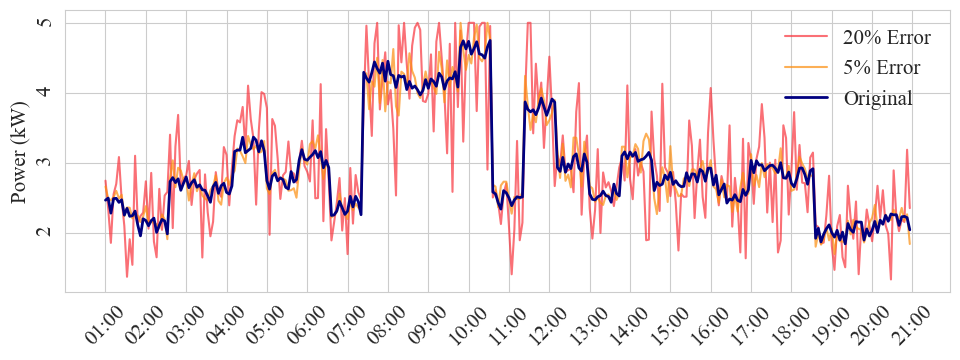

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))


# plt.plot(load_10.demand[3000:3300], label='10% Error', color='green', alpha=0.7)
plt.plot(load_20.demand[3000:3300], label='20% Error', color=colors[3], alpha=0.7)
plt.plot(load_5.demand[3000:3300],label='5% Error', color=colors[0], alpha=0.7)
plt.plot(load.demand[3000:3300], label='Original',lw=2 , alpha=1, color='navy')
plt.ylabel('Power (kW)', fontsize=15)
plt.yticks(fontsize=15, rotation=90)

# ax.spines['bottom'].set_linewidth(1.5)
# ax.spines['left'].set_linewidth(1.5)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_color('black')
plt.legend(fontsize=15, frameon=False)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=len(time_labels)//12))
ax.set_xticklabels(pv.loc[feb].index[::12].strftime('%H:%M'), rotation=45, fontsize=15)

plt.tight_layout()
plt.savefig('load_error_4.svg', dpi=300)
plt.show()

In [9]:
|colors = ['#fc8e0f', '#44af69', '#2b9eb3', '#f8333c']

# load.index = load.index.map(lambda dt: dt.replace(year=2000))
# jan = (load.index.month == 1) & (load.index.day >= 15)  #& (load.index.day <= 20)
# march = (load.index.month == 4) & (load.index.day == 17)  #& (load.index.day <= 22)
# june = (load.index.month == 6) & (load.index.day == 15)  #& (load.index.day <= 20)
# sep = (load.index.month == 9) & (load.index.day == 15)  #& (load.index.day <= 20)
# days_order = [june, march, sep, jan]
# time_labels = load.loc[jan].index.strftime('%H:%M')
# color_cycle = iter(colors)

fig, ax = plt.subplots(figsize=(12, 6))
# color = next(color_cycle)
plt.plot(load.index, load.L1)
    
# for i in range(1,4):
#     color = next(color_cycle)
#     plt.plot(load.iloc[800:1200,i], linewidth=2, alpha=0.8, color=color) # 
# plt.fill_between(time_labels, load.loc[june].L1.values*5000, load.loc[march].L1.values*5000,   alpha=0.2, color=colors[0])
# plt.fill_between(time_labels, load.loc[march].L1.values*5000, load.loc[sep].L1.values*5000,  alpha=0.2, color=colors[1])  # '#2b9eb3'
# plt.fill_between(time_labels, load.loc[sep].L1.values*5000, load.loc[jan].L1.values*5000,  alpha=0.2, color=colors[2]) #'#fc8e0f'
# plt.fill_between(time_labels, load.loc[jan].L1.values*5000, 0,  alpha=0.2, color=colors[3]) #

plt.ylabel('Load Demand (kWh)')
jan_label = mpatches.Patch(color=colors[3], label='January 15, 2020', alpha=0.8)
sep_label = mpatches.Patch(color=colors[2], label='September 15, 2020', alpha=0.8)
march_label = mpatches.Patch(color=colors[1], label='March 15, 2020', alpha=0.8)
june_label = mpatches.Patch(color=colors[0], label='June 15, 2020', alpha=0.8)

plt.legend(handles=[jan_label, march_label, june_label], fontsize=17, frameon=False)
# ax.xaxis.grid(False)
# plt.xticks(range(len(time_labels)), time_labels, rotation=45, fontsize=17)
# ax.grid(False)

ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

sns.despine()
# labels = ax.get_xticklabels()
# plt.setp(labels, x=2, ha='left')
plt.tight_layout()
# plt.xlim(weekly_avg.index.min(), weekly_avg.index[-2])
# plt.xlim(0, 23)
# plt.savefig('solar_gen5.svg', format='svg')
plt.show()

SyntaxError: invalid syntax (1062028358.py, line 1)

In [ ]:
a=0.0
for i in range(0,5):
   a += 0.97**i 
bess = 750*a

In [ ]:
a=0.0
for i in range(0,5):
    a += (0.96)**i 

pv = 1300*a
a=0.0
for i in range(0,5):
    a += (0.96)**i 
er = 250*a 

In [ ]:
print(er)

In [ ]:
print(bess)

In [ ]:
(bess + er + pv + 200)


In [ ]:
3532*(0.92**10)